# (30) Fit -- cuda1

**Motivation**: Fitting notebook, cuda1 <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from analysis.opticflow import *
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer

In [2]:
vae = VAE(ConfigVAE(
    n_kers=4,
    n_latent_scales=2, n_groups_per_scale=20, n_latent_per_group=7,
    scale_init=False, residual_kl=True, ada_groups=True,
))
tr = TrainerVAE(
    model=vae,
    cfg=ConfigTrainVAE(
        lr=0.002, batch_size=500, epochs=2000, grad_clip=1000,
        lambda_anneal=True, lambda_init=1e-7, lambda_norm=1e-4, 
        kl_beta=0.75, kl_anneal_cycles=1, kl_anneal_portion=0.3, kl_const_portion=1e-4,
        scheduler_kws={'T_max': 650.0, 'eta_min': 1e-05},
    ),
    device='cuda:1',
)
vae.cfg.total_latents()

210

In [3]:
vae.print()
vae.scales

+--------------+------------+
| Module Name  | Num Params |
+--------------+------------+
|     VAE      |  17.0 Mil  |
|     ---      |    ---     |
|     stem     |   1.1 K    |
| pre_process  |   96.0 K   |
|  enc_tower   |  9.4 Mil   |
|     enc0     |   16.6 K   |
| enc_sampler  |  1.4 Mil   |
| dec_sampler  |  1.4 Mil   |
|    expand    |   71.0 K   |
|  dec_tower   |  4.5 Mil   |
| post_process |   40.0 K   |
|     out      |    578     |
+--------------+------------+

[8, 4]

In [4]:
len(vae.all_conv_layers), len(vae.all_log_norm)

(291, 228)

## Review train options

In [5]:
print(f"{vae.cfg.name()}\n{tr.cfg.name()}")

k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep2000-b500-lr(0.002)_beta(0.75:1x0.3)_lamb(0.0001)_gr(1000)

## Train

In [6]:
comment = f"Clamp(4)+WeakLambda+StrongBeta_{tr.cfg.name()}"
tr.train(comment=comment)

gstep # 9.6e+04, nelbo: 25.361, grad: 45.3:  60%|██████    | 1200/2000 [18:44:49<12:29:53, 56.24s/it]                    


KeyboardInterrupt: 

## Eval

In [7]:
%%time

val, loss = tr.validate(use_ema=False)
val_ema, loss_ema = tr.validate(use_ema=True)

CPU times: user 24.9 s, sys: 10.5 s, total: 35.4 s
Wall time: 1min 7s


In [8]:
loss_summary = {
    k: {
        'vae': np.round(v.mean(), 2),
        'ema': np.round(loss_ema[k].mean(), 2),
    } for k, v in loss.items()
}
print(f"{vae.cfg.name()}\n{tr.cfg.name()}\n\n{loss_summary}\n")

k-32_z-7x[10,20]_enc(2x2)-dec(2x1)-pre(1x3)-post(1x3)
ep2000-b500-lr(0.002)_beta(0.25:1x0.3)_lamb(0.001)_gr(1000)

{'epe': {'vae': 3.79, 'ema': 3.79}, 'kl': {'vae': 37.61, 'ema': 37.47}}

fig/sample (VAE)

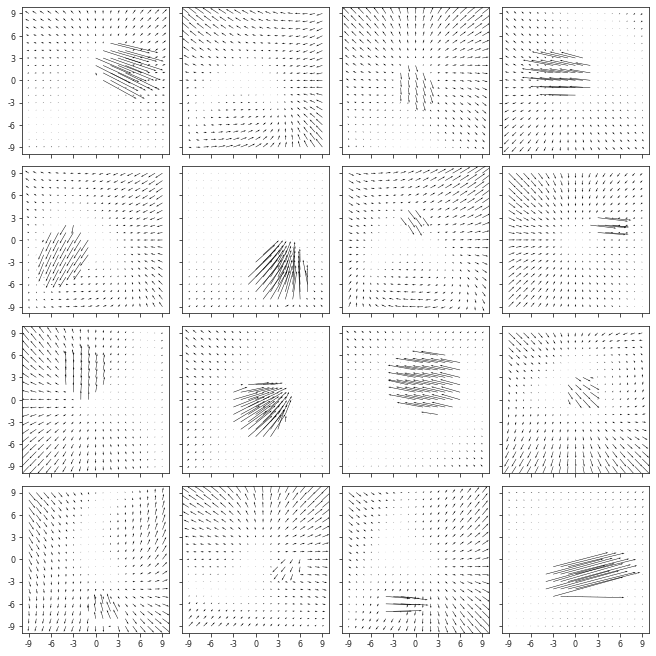

fig/sample (EMA)

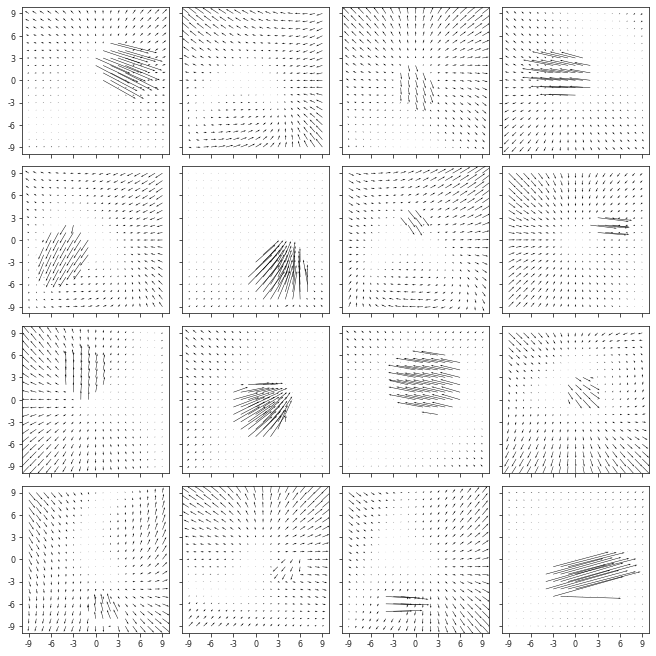

----------------------------------------------------------------------

fig/regression (VAE)

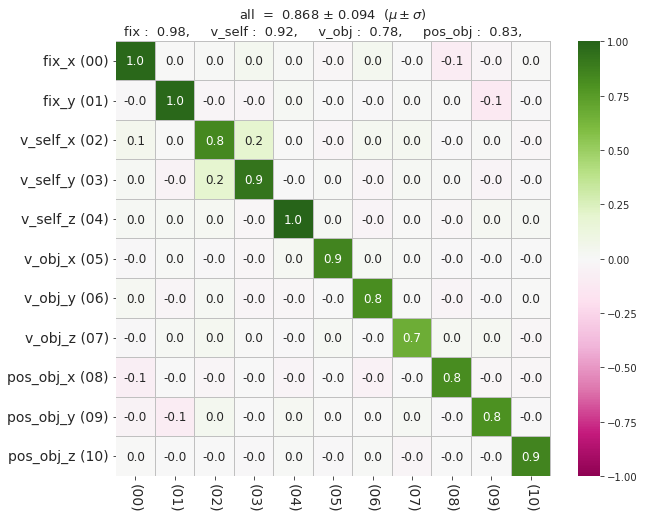

fig/regression (EMA)

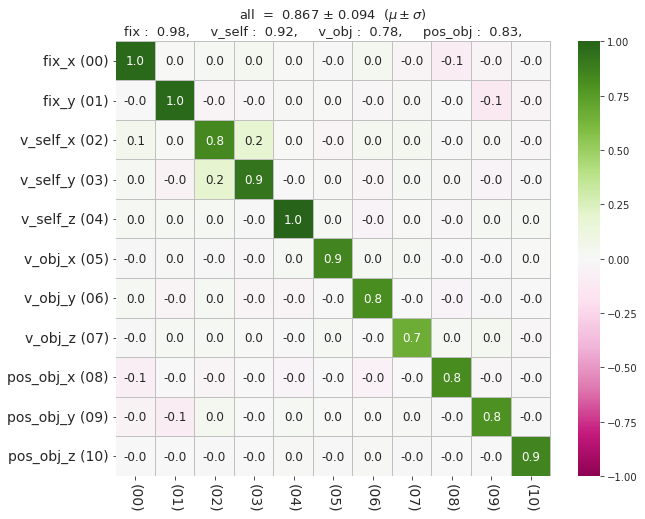

----------------------------------------------------------------------

fig/mutual_info (VAE)

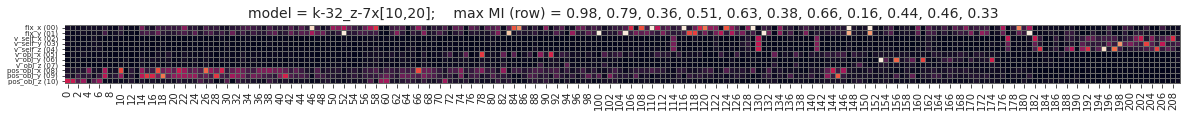

fig/mutual_info (EMA)

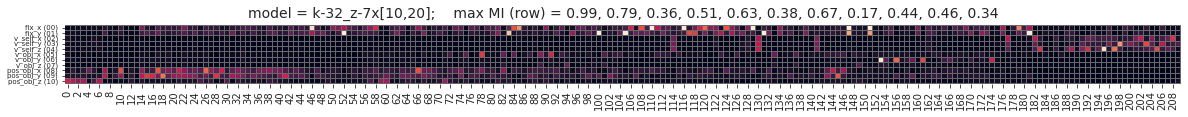

----------------------------------------------------------------------

In [9]:
for k, v in val.items():
    if 'fig' in k:
        print(f"{k} (VAE)")
        display(v)
        print(f"{k} (EMA)")
        display(val_ema[k])
        print('-' * 70)

In [13]:
len(tr.stats['grad'])

482

In [14]:
np.quantile(tr.stats['grad'], [0.5, 0.7, 0.9, 1])

array([5.99852881e+03, 3.31414691e+04, 6.06242619e+05, 3.20467665e+11])

In [15]:
np.quantile(tr.stats['loss'], [0.5, 0.7, 0.9, 1])

array([1.83597097e+01, 3.33677979e+01, 1.99485512e+02, 5.41584938e+05])

In [16]:
gamma = np.stack(tr.stats['gamma'])
gamma.shape

(160000, 30)

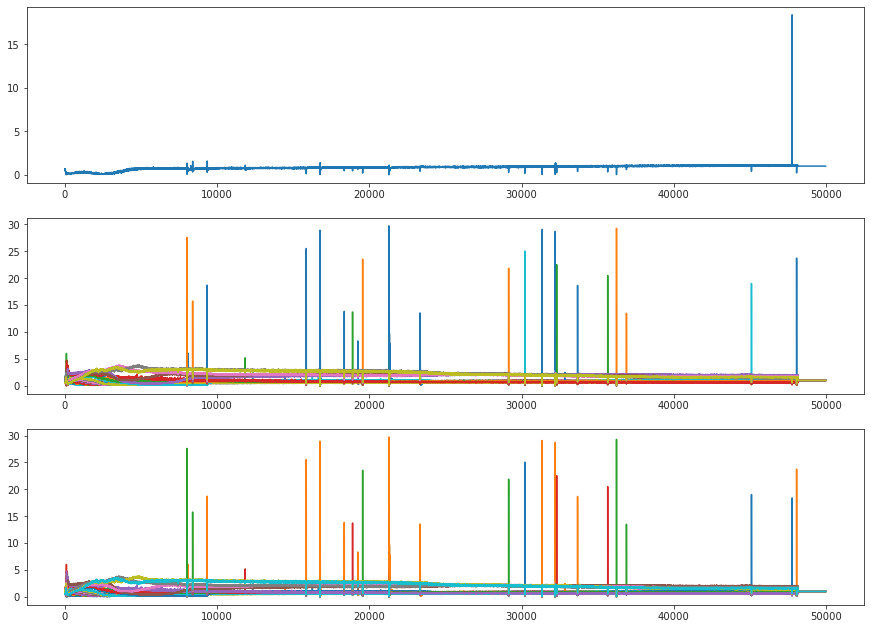

In [17]:
fig, axes = create_figure(3, 1, (15, 11))
axes[0].plot(gamma[:50000, 0])
axes[1].plot(gamma[:50000, 1:])
axes[2].plot(gamma[:50000]);